# Multi-label Text Classification with BERT and PyTorch Lightning

In [ ]:
!pip install pytorch-lightning==1.2.8 --quiet
!pip install transformers==4.5.1 --quiet

     |████████████████████████████████| 841 kB 35.2 MB/s 
     |████████████████████████████████| 596 kB 69.5 MB/s 
     |████████████████████████████████| 140 kB 74.5 MB/s 
     |████████████████████████████████| 419 kB 73.0 MB/s 
     |████████████████████████████████| 829 kB 65.3 MB/s 
     |████████████████████████████████| 1.1 MB 62.8 MB/s 
     |████████████████████████████████| 144 kB 67.5 MB/s 
     |████████████████████████████████| 271 kB 64.1 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 2.1 MB 29.8 MB/s 
     |████████████████████████████████| 3.3 MB 59.2 MB/s 
     |████████████████████████████████| 880 kB 53.0 MB/s 


In [ ]:
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 16.5 MB/s 
     |████████████████████████████████| 831.4 MB 2.8 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

## Data

Our dataset contains potentially offensive (toxic) comments and comes from the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Let's start by download the data (from Google Drive):

Let's load and look at the data:

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Toxicity Classification/train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


We have text (comment) and six different toxic labels. Note that we have clean content, too. 

Let's split the data:

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape

((151592, 8), (7979, 8))

In [ ]:
LABEL_COLUMNS = df.columns.tolist()[2:]

## Preprocessing


In [ ]:
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

In [ ]:
train_df = pd.concat([
  train_toxic,
  train_clean.sample(15_000)
])

train_df.shape, val_df.shape

((30427, 8), (7979, 8))

### Tokenization

We need to convert the raw text into a list of tokens. For that, we'll use the built-in BertTokenizer:

In [ ]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Let's try it out on a sample comment:

In [ ]:
sample_row = df.iloc[16]
sample_comment = sample_row.comment_text
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels.to_dict())

Bye! 

Don't look, come or think of comming back! Tosser.

{'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}


In [ ]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

The result of the encoding is a dictionary with token ids `input_ids` and an attention mask `attention_mask` (which tokens should be used by the model 1 - use or 0 - don't use).

Let's look at their contents:

In [ ]:
encoding["input_ids"].squeeze()[:20]

tensor([  101, 17774,   106,  1790,   112,   189,  1440,   117,  1435,  1137,
         1341,  1104,  3254,  5031,  1171,   106,  1706, 14607,   119,   102])

In [ ]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

You can also inverse the tokenization and get back (kinda) the words from the token ids:

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'Bye', '!', 'Don', "'", 't', 'look', ',', 'come', 'or', 'think', 'of', 'com', '##ming', 'back', '!', 'To', '##sser', '.', '[SEP]']


We need to specify the maximum number of tokens when encoding (512 is the maximum we can do). Let's check the number of tokens per comment.

In [ ]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["comment_text"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)

Most of the comments contain less than 300 tokens or more than 512. So, we'll stick with the limit of 512.

In [ ]:
MAX_TOKEN_COUNT = 512

### Dataset

We'll wrap the tokenization process in a PyTorch Dataset, along with converting the labels to tensors:

In [ ]:
class ToxicCommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.comment_text
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

Let's have a look at a sample item from the dataset:

In [ ]:
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
sample_item["input_ids"].shape

torch.Size([512])

Let's load the BERT model and pass a sample of batch data through:

In [ ]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

In [ ]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [ ]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [ ]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 512, 768]), torch.Size([8, 768]))

In [ ]:
class ToxicCommentDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

`ToxicCommentDataModule` encapsulates all data loading logic and returns the necessary data loaders. Let's create an instance of our data module:

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 12

data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

## Model

Our model will use a pre-trained BertModel


In [ ]:
class ToxicCommentTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

Most of the implementation is just a boilerplate. Two points of interest are the way we configure the optimizers and calculating the area under ROC. We'll dive a bit deeper into those next.

### Optimizer scheduler

The job of a scheduler is to change the learning rate of the optimizer during training. This might lead to better performance of our model. We'll use the [get_linear_schedule_with_warmup](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup).

Let's have a look at a simple example to make things clearer:

In [ ]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

We'll use a fifth of the training steps for a warm-up:

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(5070, 25350)

We can now create an instance of our model:

In [ ]:
model = ToxicCommentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

### Evaluation

Multi-label classification boils down to doing binary classification for each label/tag.

We'll use Binary Cross Entropy to measure the error for each label. PyTorch has [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), which we're going to combine with a sigmoid function (as we did in the model implementation). Let's look at an example:

In [ ]:
criterion = nn.BCELoss()

prediction = torch.FloatTensor(
  [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor(
  [1., 0., 0., 0., 1., 0.]
) 

In [ ]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [ ]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.8725)

We can use the same approach to calculate the loss of the predictions:

In [ ]:
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.3963, 0.6318, 0.6543, 0.5179, 0.4099, 0.4998],
        [0.4008, 0.6165, 0.6733, 0.5460, 0.4378, 0.5083],
        [0.3877, 0.6185, 0.6830, 0.5238, 0.4326, 0.5138],
        [0.3910, 0.6206, 0.6658, 0.5431, 0.4396, 0.5002],
        [0.3792, 0.6241, 0.6508, 0.5347, 0.4374, 0.5110],
        [0.4069, 0.6106, 0.7019, 0.5484, 0.4450, 0.4995],
        [0.3861, 0.6135, 0.6867, 0.5179, 0.4525, 0.5188],
        [0.3819, 0.6081, 0.6821, 0.5227, 0.4419, 0.5246]],
       grad_fn=<SigmoidBackward>)

In [ ]:
criterion(predictions, sample_batch["labels"])

tensor(0.8056, grad_fn=<BinaryCrossEntropyBackward>)

#### ROC Curve

Another metric we're going to use is the area under the Receiver operating characteristic (ROC) for each tag. ROC is created by plotting the True Positive Rate (TPR) vs False Positive Rate (FPR):

$$
\text{TPR} = \frac{\text{TP}}{\text{TP} \text{+} \text{FN}}
$$

$$
\text{FPR} = \frac{\text{FP}}{\text{FP} \text{+} \text{TN}}
$$




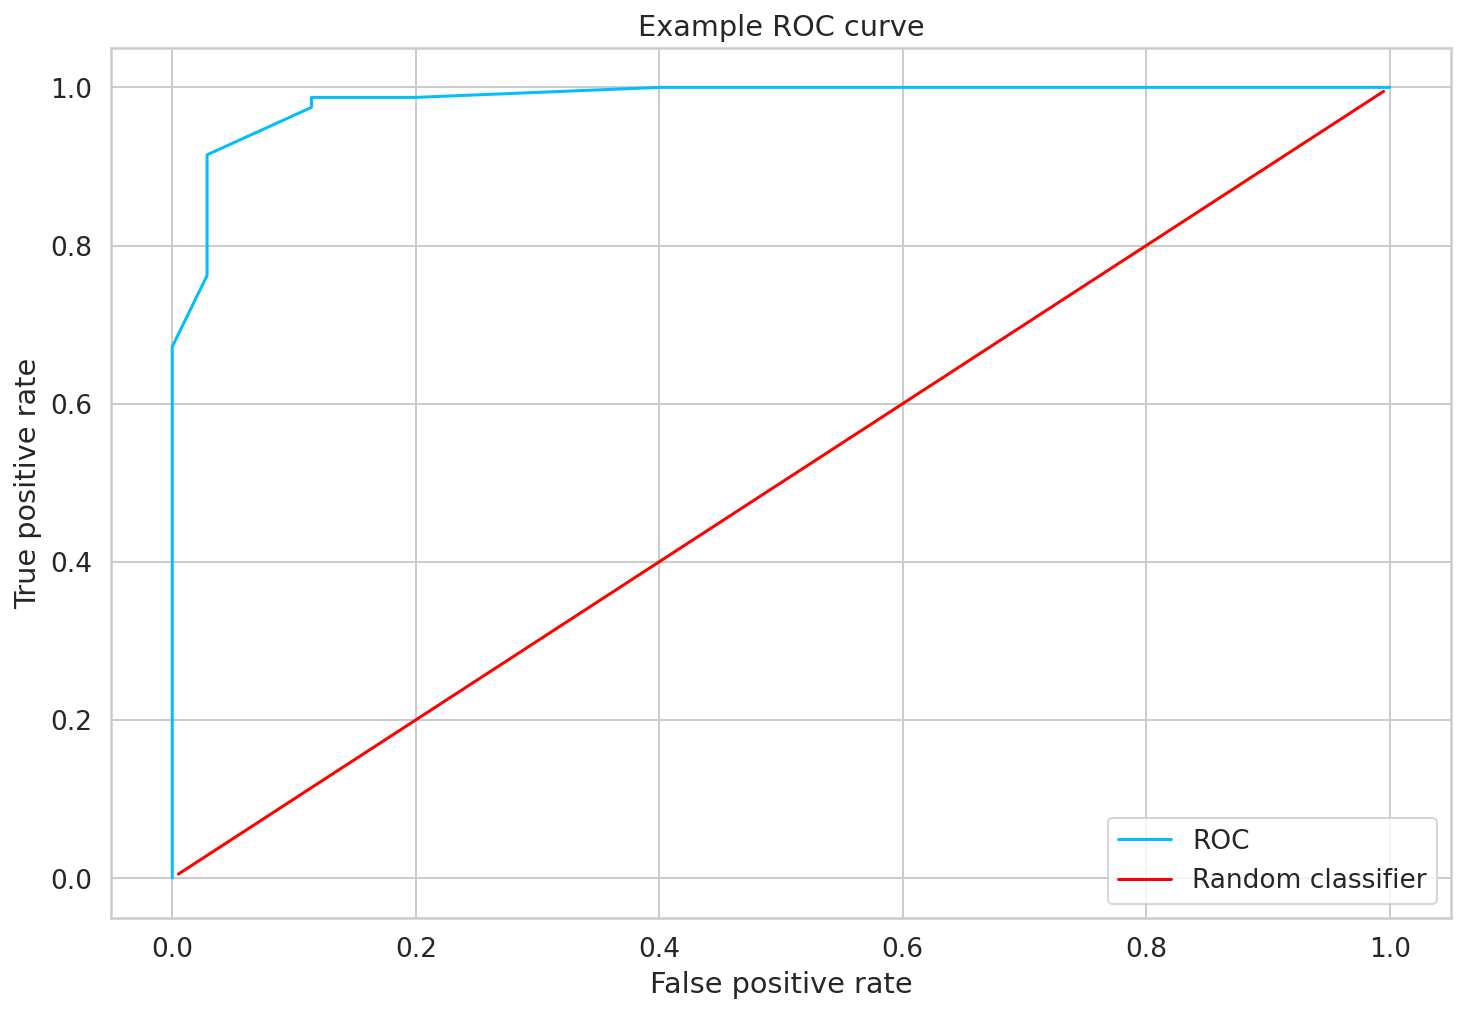

In [ ]:
from sklearn import metrics



_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();

## Training

In [ ]:
!rm -rf lightning_logs/
!rm -rf checkpoints/

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

We can start the training process:

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 4.6 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.260   Total estimated model params size (MB)


Epoch 0, global step 2535: val_loss reached 0.05723 (best 0.05723), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Epoch 1, global step 5071: val_loss reached 0.04705 (best 0.04705), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Epoch 2, step 7607: val_loss was not in top 1


Epoch 3, step 10143: val_loss was not in top 1


1

In [ ]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.04704693332314491}
--------------------------------------------------------------------------------


[{'test_loss': 0.04704693332314491}]

## Predictions

I like to look at a small sample of predictions after the training is complete. This builds intuition about the quality of the predictions (qualitative evaluation).

In [ ]:
trained_model = ToxicCommentTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

We put our model into "eval" mode, and we're ready to make some predictions. Here's the prediction on a sample (totally fictional) comment:

In [ ]:
THRESHOLD = 0.5

test_comment = "You are such a loser! You'll regret everything you've done to me!"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

toxic: 0.9569520354270935
insult: 0.7289626002311707


## Evaluation

Let's get a more complete overview of the performance of our model. We'll start by taking all predictions and labels from the validation set:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = ToxicCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

One simple metric is the accuracy of the model:

In [ ]:
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.9813)

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per class
toxic: 0.985722541809082
severe_toxic: 0.990084171295166
obscene: 0.995059609413147
threat: 0.9909615516662598
insult: 0.9884428977966309
identity_hate: 0.9890572428703308
